# plot FOV ovals on the ground

In [1]:
#  d duncan, 04/02/19
#  using Ellipse class of objects to map correct size and orientation of FOVs
#  on the ground from AMSR2 L1 data

from h5py import File
from matplotlib.patches import Ellipse
from cartopy import crs as ccrs
from cmocean import cm as cmo

In [2]:
# read in L1R file and calculate spacecraft position in terms of geocentric lat/lon
afile = '/home/dudavid/src/1dvar/ocean_goes5_AMSR2/GW1AM2_201609211515_089A_L1SGRTBR_2220220.h5'
dorb = afile[-35:-20]
amf = File(afile)

altitude = 1e3* float(bytes.decode(amf.attrs['SatelliteAltitude'][0])[:-2]) # assumed constant for all scans
print(altitude,'m')
navd = amf['Navigation Data'][:] # first 3 are X,Y,Z in WGS84 positioning
print(navd.shape)
# azimuth angle of FOV, relative to N, [-180<az<180] (scaled in h5 file)
az   = amf['Earth Azimuth'][30:-30,:]*.01 

#zen  = amf['Earth Incidence'][:,30:-30]*.01 

# choose channels and convolution resolution (these are native except 89!)
tblist = ['Brightness Temperature (res06,6.9GHz,V)','Brightness Temperature (res06,6.9GHz,H)',\
          'Brightness Temperature (res06,7.3GHz,V)','Brightness Temperature (res06,7.3GHz,H)',\
          'Brightness Temperature (res10,10.7GHz,V)','Brightness Temperature (res10,10.7GHz,H)',\
          'Brightness Temperature (res23,18.7GHz,V)','Brightness Temperature (res23,18.7GHz,H)',\
          'Brightness Temperature (res23,23.8GHz,V)','Brightness Temperature (res23,23.8GHz,H)',\
          'Brightness Temperature (res36,36.5GHz,V)','Brightness Temperature (res36,36.5GHz,H)',\
          'Brightness Temperature (original,89GHz-A,V)','Brightness Temperature (original,89GHz-A,H)' ] 
nch = len(tblist)
ch_str = ['6V','6H','7V','7H','10V','10H','18V','18H','23V','23H','36V','36H','89V','89H']
npix = 243
nscans = np.shape(amf[tblist[0]][:])[0] 
print(nscans)
tbs = np.zeros([nscans,npix,nch])
for c,chstr in enumerate(tblist):
    if c<nch-2:  # last 2 in list have 486 pixels across
        tbs[:,:,c] = .01 * amf[chstr][:,:]  # tbs saved with factor 100
    else:
        tbs[:,:,c] = .01 * amf[chstr][:,::2]  # take every other original 89 to match low freqs

# NOTE: there are 30 'overlap' scans included on either end of JAXA files, so shrink array to match L1C:
nscans -= 30*2
tbs = tbs[30:-30, :, :] #.reshape(nscans*npix,nch)
print(shinfo(tbs),nscans)    

alo = amf['Longitude of Observation Point for 89A'][30:-30,::2] # every other one has a low-freq
ala = amf['Latitude of Observation Point for 89A'][30:-30,::2]  # obs point (half the sampling)
amf.close()

from astropy.coordinates import EarthLocation
# ploc = EarthLocation.from_geodetic(lo[sc,px],la[sc,px], altitude,ellipsoid='WGS84')\n",
# sloc = EarthLocation.from_geocentric(navd[sc,0],navd[sc,1],navd[sc,2], unit='m') # for SC lat/lon/etc.\n",
# SClat, SClon = sloc.lat.value, sloc.lon.value\n",
# sensor_losGeometricFromSensorPosToOtherPositions will draw the line between two distinct points \n",
#   such as SCposition and position on the ground
SClat, SClon = np.zeros([nscans]), np.zeros([nscans])  ## just get SClat/SClon once per scan
sloc = EarthLocation.from_geocentric(navd[30:-30,0],navd[30:-30,1],navd[30:-30,2], unit='m')
SClat[:], SClon[:] = sloc.lat.value, sloc.lon.value
#SClat[xpx,xsc], SClon[xpx,xsc] = sloc.lat.value, sloc.lon.value
print(info(ala[:,122]-SClat))
#print(ala[122,1000],SClat[1000])

699600.0 m
(2041, 6)
2041
['7.47E+1', '3.75E+2', '1.87E+2', '5.50E+1', (1981, 243, 14)] 1981
['-3.13E+0', '7.48E+0', '6.79E+0', '1.71E+0']


In [3]:
# pick a scan number, then select a range of pixels/scans around it in a square
scm = 1000 # scan midpoint of 2D scene


# Lats and lons
lat0     = 0  # center of grid in lat, lon
lon0     = 0
nlat, nlon = 10, 10    # number of lat and lon divisions
latwid, lonwid = 4, 4  # just asssume square for now
 
lat_grid = lat0 + np.linspace(-latwid,latwid,nlat) # [-3:0.25:3]
lon_grid = lon0 + np.linspace(-lonwid,lonwid,nlat) # [-3:0.25:3]
 

In [4]:
# Surface properties

s_names = ['Water skin temperature','Wind speed','Wind direction','Salinity']
s_data = np.zeros([len(s_names), lat_grid.size, lon_grid.size])

tmean                     = 296   # sst mean
wsp                       = 7.3   # 10m wind speed
s_data[0,:,:] = tmean
s_data[0,2,4] = tmean+3.5 # some preturbation
s_data[1,:,:] = wsp
s_data[1,5,1] = wsp-3.2 # some perturbation
s_data[2,:,:] = 90 # token wind direction value
s_data[3,:,:] = 0.034 # token salinity value


In [5]:
widths  = np.array([35., 34., 24., 14., 15.,  7., 3.]) # in km across
heights = np.array([62., 58., 42., 22., 26., 12., 5.]) #  per freq, 6/7/10/18/23/36/89

# convert (roughly!) to deg near equator... okay as first approximation for plotting:
dwidths = widths*360.0/40075.
print(info(dwidths))
#dwidths *= np.cos(20*np.pi/180)
#print(info(dwidths))
dheights= heights*360.0/40075. # deg/circumference

### if wanting to get more exact with widths/heights of FOVs, can back out lat/lon differences
###  for edge of FOVs using positions with this package:
#from astropy import coordinates
#from astropy.coordinates import EarthLocation
#ploc = EarthLocation.from_geodetic(arts_pos[0,0,1],arts_pos[0,0,0], 0.0,ellipsoid='WGS84')
#ploc.

['2.69E-2', '3.14E-1', '1.69E-1', '1.04E-1']


(6804,)


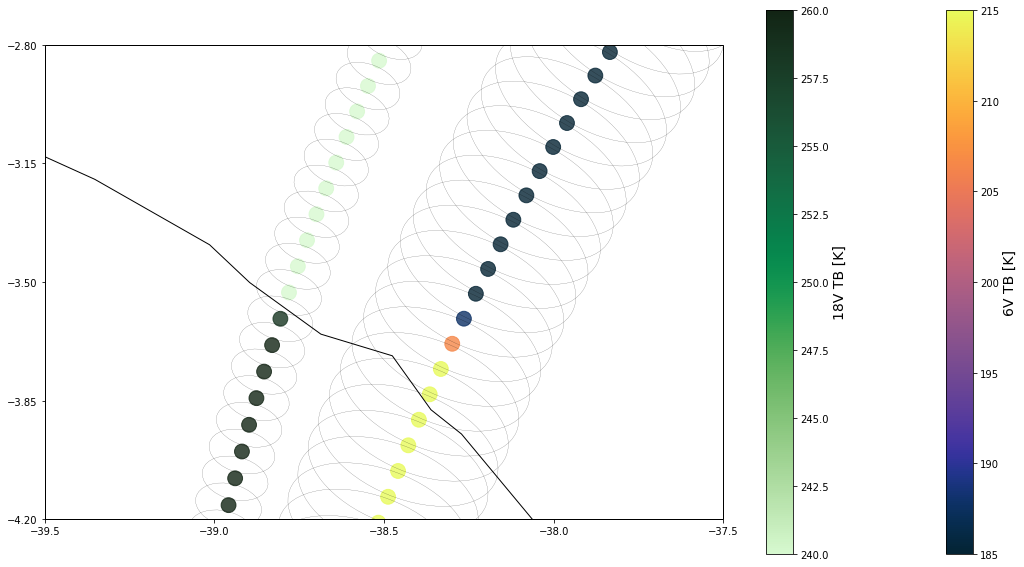

In [6]:

sc = 1000
off = 10 # next scan

# provide x,y coords, width, height, angle of ellipse

ells = [Ellipse(xy=[alo[i,j],ala[i,j]], width=dwidths[int(k/2)], height=dheights[int(k/2)], 
                angle=-az[i,j], linewidth=0.2, alpha=0.7, fill=False) 
        for i in np.arange(sc,sc+off+1,off) for j in range(npix) for k in range(nch)]
print(np.shape(ells))

#ax.fill(x, y, alpha=0.2, facecolor='yellow',
#        edgecolor='yellow', linewidth=1, zorder=1)
#ax.add_patch()

fig = plt.figure(figsize=[19,10])
projj = ccrs.PlateCarree()
ax = plt.subplot(111, projection=projj )

inn = 1.5 # additional deg or whatever on each side beyond lat/lon values
reg = [np.min(ala[sc,:])-inn,np.max(ala[sc,:])+inn+.8, 
       np.min(alo[sc,:])-inn,np.max(alo[sc,:])+inn]
reg=[-4.2,-2.8,-39.5,-37.5]  ## region is close to Fortaleza, Brazil
#ax.set_xlim(left=np.min(lon_grid)+inn,right=np.max(lon_grid)-inn)
#ax.set_ylim(bottom=np.min(lat_grid)+inn,top=np.max(lat_grid)-inn)
ax.set_xlim(left=reg[2], right=reg[3])
ax.set_ylim(bottom=reg[0], top=reg[1])

nx,ny = 5,5
ax.set_xticks( np.linspace(reg[2],reg[3], nx) )
ax.set_yticks( np.linspace(reg[0],reg[1], ny) )

othr=6
for e in ells[0::nch][0:npix]: #[-npix:-1]:  # 19V
    ax.add_artist(e)
for e in ells[othr::nch][npix:]: #[-npix:-1]:  # so just 6V right now, first scan
    ax.add_artist(e)

ann = 30
#vmin = np.min(tbs[sc:sc+off+1,:,0]) + ann
#vmax = np.max(tbs[sc:sc+off+1,:,0]) - ann
vmin0, vmax0= 200-15, 200+15
thenorm = plt.Normalize(vmin = vmin0, vmax = vmax0)
#vmin = np.min(tbs[sc:sc+off+1,:,othr]) + ann*2
#vmax = np.max(tbs[sc:sc+off+1,:,othr]) - ann*2
vmin1, vmax1 = 250-10, 250+10
thenorm1 = plt.Normalize(vmin = vmin1, vmax = vmax1)
ceem1, ceem = cmo.algae, cmo.thermal
#ax.pcolormesh(lon_grid, lat_grid, s_data[0,:,:], norm=thenorm1, 
#             transform=projj, cmap=cmo.algae)

#thenorm=plt.Normalize(vmin=vmin,vmax=vmax)
ax.scatter( alo[sc+off,:], ala[sc+off,:], s=220.0, c=tbs[sc+off,:,othr], marker='o', \
            transform=projj, alpha=0.8, cmap=ceem1, norm=thenorm1);
ax.scatter( alo[sc,:], ala[sc,:],         s=220.0, c=tbs[sc,:,0], marker='o', \
            transform=projj, alpha=0.8, cmap=ceem, norm=thenorm);
ax.coastlines(resolution='50m');

fs = 14
sm = plt.cm.ScalarMappable(cmap=ceem, norm=thenorm)
sm._A = []
cb = plt.colorbar(sm,ax=ax)
cb.set_label(ch_str[0]+' TB [K]', fontsize=fs)

sm1 = plt.cm.ScalarMappable(cmap=ceem1, norm=thenorm1)
sm1._A = []
cb1 = plt.colorbar(sm1,ax=ax)
cb1.set_label(ch_str[othr]+' TB [K]', fontsize=fs)

#plt.savefig('sample_fovsz.png',bbox_inches='tight',dpi=400)
plt.show()


(150,)
(1981, 243)


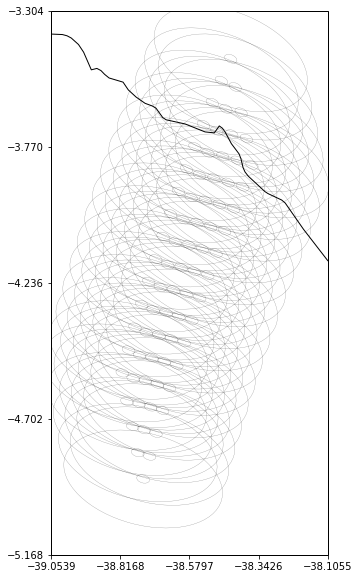

In [7]:

#sc = 1000
#off = 1 # next scan
pixr = np.arange(215,230)
scr  = np.arange(1000,1000+5)
chans = [0,12] # trying 6,89

# provide x,y coords, width, height, angle of ellipse

ells2 = [Ellipse(xy=[alo[i,j],ala[i,j]], width=dwidths[int(k/2)], height=dheights[int(k/2)], 
                angle=-az[i,j], linewidth=0.25, alpha=0.5, fill=False) 
        for i in scr for j in pixr for k in chans]
print(np.shape(ells2))

fig = plt.figure(figsize=[19,10])
projj = ccrs.PlateCarree()
ax = plt.subplot(111, projection=projj )

inn = .26
print(np.shape(ala))
reg = [np.min(ala[scr[0]:scr[-1],pixr])-inn, np.max(ala[scr[0]:scr[-1],pixr])+inn, 
       np.min(alo[scr[0]:scr[-1],pixr])-inn, np.max(alo[scr[0]:scr[-1],pixr])+inn]
ax.set_xlim(left=reg[2], right=reg[3])
ax.set_ylim(bottom=reg[0], top=reg[1])

nx,ny = 5,5
ax.set_xticks( np.linspace(reg[2],reg[3], nx) )
ax.set_yticks( np.linspace(reg[0],reg[1], ny) )

for e in ells2[:]: # one of each freq
    ax.add_artist(e)

#vmin=np.min(tbs[:,:,0])-1
#vmax=np.max(tbs[:,:,0])+1
#thenorm=plt.Normalize(vmin=vmin,vmax=vmax)
#ax.scatter( alo[sc,:], ala[sc,:], s=60.0, c=tbs[sc,:,0], marker='o', \
#            transform=projj, alpha=0.8, cmap=cmo.thermal, norm=thenorm);
ax.coastlines(resolution='10m');
#sm = plt.cm.ScalarMappable(cmap=cmo.thermal, norm=thenorm)
#sm._A = []
#plt.colorbar(sm,ax=ax)

#plt.savefig('ring_fovs.png',bbox_inches='tight',dpi=400)
plt.show()

In [9]:
# area of ellipse: A=pi*a*b where a,b are radii of major and minor axes
#  so area of 6.9GHz FOV (35x62km): A = pi*17.5*31 = 
A = np.pi*(widths/2)*(heights/2)  # in km^2
print(A)
rec_dif = widths*heights - A
print(rec_dif,rec_dif/A)

[1704.31401457 1548.80517822  791.6813487   241.90263433  306.30528373
   65.97344573   11.78097245]
[465.68598543 423.19482178 216.3186513   66.09736567  83.69471627
  18.02655427   3.21902755] [0.27323954 0.27323954 0.27323954 0.27323954 0.27323954 0.27323954
 0.27323954]


In [10]:


width  = 1.5           # Max half-width of antenna simulated (if HPBW is 1.8deg, width=2 covers 2x the HPBW)
resol  = 0.01          # angular resolution (same in zenith/azimuth)
# note: for a given angular resolution (might vary), width=2 yields 99.96% of total power @6GHz 
#   compared to width=20 and 99.99999% @10GHz, width=1.5 yields 99.0 and 99.994 @ 6,10
#resol, width = dang/(angfac*5), awidth # set here instead of calling func
print('angular resolution of response grid [deg]: ',resol)

adata = [[ 6.925e9 ,  1.80],   # AMSR2 center frequency and beamwidth (deg)
         [ 7.300e9 ,  1.80],   # assumed the same for V/H polarizations
         [ 10.65e9 ,  1.20],
         [ 18.70e9 ,  0.65],
         [ 23.80e9 ,  0.75],
         [ 36.50e9 ,  0.35],
         [ 89.00e9 ,  0.15]] 

adata = np.array(adata, order="C").transpose()[:,:] #fsub] # choose selected frequencies (set above)

# define zenith, azimuth grid on the ground (relative to bore sight) -- assumed to be square, 2xWidth wide
x  = np.arange( -width, width+resol, resol )  #this gives angular antenna response points in za,aa
x2 = x**2   # since assumed origin is 0, do squaring here 
nf, nx = len(adata[0,:]), np.size(x)   # num frequencies, size of antenna grid

#print(ch_str)

from typhon.arts.griddedfield import GriddedField4
gf4 = GriddedField4()   # ARTS variable type, found in typhon
gf4.name = 'AMSR2 antenna response'
gf4.gridnames =  [ 'Polarisation', 'Frequency', 'Zenith angle', 'Azimuth angle' ]
###  note: za & aa are equally spaced, and we're treating V/H as having identical responses
#if npol==2: gsp="1" 
#else: gsp="0"
gsp="1"
gf4.grids     = [ [gsp], adata[0,:], x, x ]
gf4.dataname  = 'Response'
gf4.data      = np.zeros([ 1, nf, nx, nx ], order="C")
print('size of antenna_reponse grid: ',gf4.data.shape)

for i in range(nf):
    si = adata[1,i] / (2*np.sqrt(2*np.log(2)))  # calculate standard deviation first, based on HPBW
    gf4.data[0,i,:,:] = np.exp( - np.tile(x2,[nx,1])/si**2 - np.tile(x2,[nx,1]).transpose()/ si**2 )

#plt.pcolormesh(gf4.data[0,0,:,:])# to plot antenna pattern of one freq
#plt.show()

angular resolution of response grid [deg]:  0.01
size of antenna_reponse grid:  (1, 7, 301, 301)


In [49]:
aresol = 0.10
zresol = 0.15
aa_grid = np.arange(-width+aresol, width, aresol)
za_grid = np.arange(-width+zresol, width, zresol)
angx, angy = np.meshgrid(za_grid,aa_grid)
ang_grid = np.ones_like(angx)
#print(aa_grid,za_grid)

[-1.40000000e+00 -1.30000000e+00 -1.20000000e+00 -1.10000000e+00
 -1.00000000e+00 -9.00000000e-01 -8.00000000e-01 -7.00000000e-01
 -6.00000000e-01 -5.00000000e-01 -4.00000000e-01 -3.00000000e-01
 -2.00000000e-01 -1.00000000e-01  1.33226763e-15  1.00000000e-01
  2.00000000e-01  3.00000000e-01  4.00000000e-01  5.00000000e-01
  6.00000000e-01  7.00000000e-01  8.00000000e-01  9.00000000e-01
  1.00000000e+00  1.10000000e+00  1.20000000e+00  1.30000000e+00
  1.40000000e+00] [-1.3500000e+00 -1.2000000e+00 -1.0500000e+00 -9.0000000e-01
 -7.5000000e-01 -6.0000000e-01 -4.5000000e-01 -3.0000000e-01
 -1.5000000e-01 -8.8817842e-16  1.5000000e-01  3.0000000e-01
  4.5000000e-01  6.0000000e-01  7.5000000e-01  9.0000000e-01
  1.0500000e+00  1.2000000e+00  1.3500000e+00]


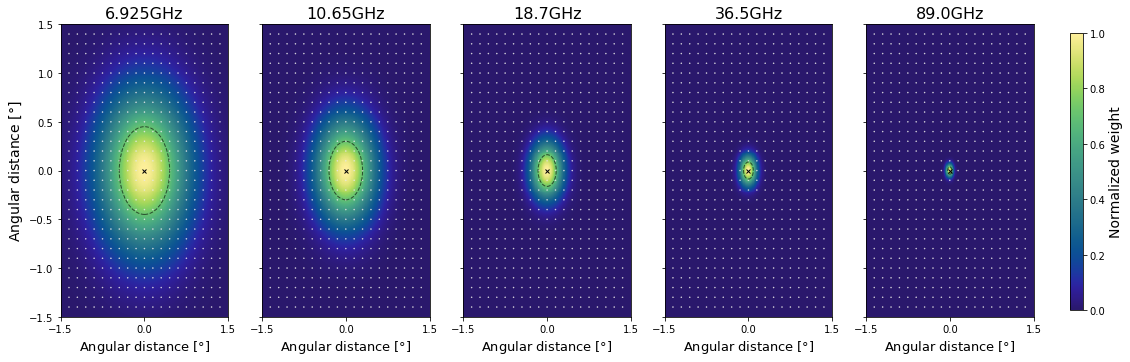

In [51]:
# plot 5 panel antenna responses with overlaid ellipses (actually circles in this case?) for HPWB visualization 
plt_hpbw = [0,2,3,5,6] #[1.8,1.2,.65,.35,.15]
str_frq = ['6.925GHz','7.30GHz','10.65GHz','18.7GHz','23.8GHz','36.5GHz','89.0GHz'] #[plt_hpbw]
nxp = len(plt_hpbw)
circ = [Ellipse(xy=[0,0], width=(i/2), height=(i/2), 
                angle=0, linewidth=1.0, linestyle='--', alpha=0.6, fill=False) 
        for i in adata[1,plt_hpbw] ]

f, ax = plt.subplots(1,nxp, sharey=True, figsize=[17,5.5])
fs = 14
import cmocean as cem
for i in range(nxp):
    bb = ax[i].pcolormesh(x,x,gf4.data[0,plt_hpbw[i],:,:], cmap=cem.cm.haline)
    ax[i].set_title(str_frq[plt_hpbw[i]], fontsize=fs+2)
    ax[i].add_artist( circ[i] )
    ax[i].set_aspect( 1/np.cos(55*np.pi/180))
    ax[i].set_xlabel('Angular distance [$\degree$]', fontsize=fs-1)
    ax[i].set_xticks([-width,0,width])
    ax[i].plot(0,0, marker='x', color='black', markersize=4.5)
    #if i==2:
    ax[i].scatter(angx, angy, c=ang_grid, marker='.', s=1, cmap='gray',vmin=0,vmax=1.1)
ax[0].set_ylabel('Angular distance [$\degree$]', fontsize=fs)
cbar_ax = f.add_axes([0.95, 0.15, 0.01, 0.7])
cb = f.colorbar(bb, cax=cbar_ax, orientation='vertical')#, label='Normalized weight')
cb.set_label('Normalized weight', fontsize=fs)
plt.subplots_adjust( right=.92) # wspace adjustment doesnt work if figsize and aspect are set?
pvr = 'v2'
f.savefig('img/antenna_patterns_'+str(nxp)+'pan_'+pvr+'.png', bbox_inches='tight', dpi=300)
plt.show()

In [13]:

# plot FOVs near hawaii from an orbit on same date?
dire= '/home/dudavid/Dendrite/Dendrite/UserAreas/Dave/AMSR2_L1R/'
fil = File(dire+'GW1AM2_201609212329_169A_L1SGRTBR_2220220.h5')
alo = fil['Longitude of Observation Point for 89A'][30:-30,::2] # every other one has a low-freq
ala = fil['Latitude of Observation Point for 89A'][30:-30,::2]  # obs point (half the sampling)
tb6h = fil['Brightness Temperature (res06,6.9GHz,H)'][30:-30,:]*.01
az  = fil['Earth Azimuth'][30:-30,:]*.01 
fil.close()

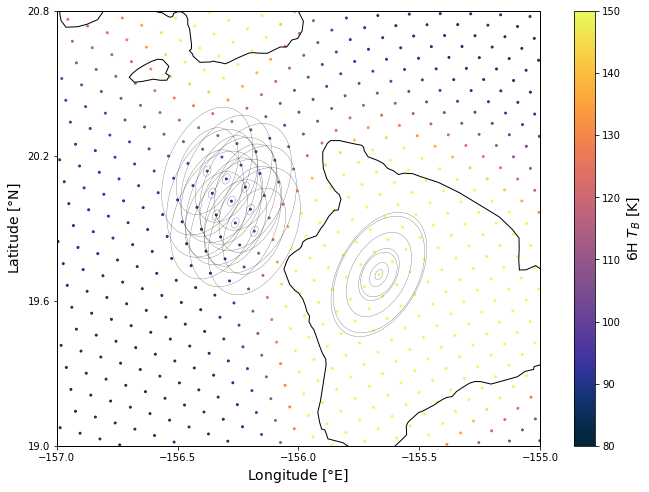

In [34]:

pxr = np.arange(70,73)#243)
scr  = np.arange(1220,1220+3)
chans = [0,4,12]

ells_hw = [Ellipse(xy=[alo[i,j],ala[i,j]], width=dwidths[int(k/2)]/np.cos(20*np.pi/180), height=dheights[int(k/2)], 
                angle=-az[i,j], linewidth=0.25, alpha=0.8, fill=False) 
        for i in scr for j in pxr for k in chans]
ells_hw1 = [Ellipse(xy=[alo[i,j],ala[i,j]], width=dwidths[int(k/2)]/np.cos(20*np.pi/180), height=dheights[int(k/2)], 
                angle=-az[i,j], linewidth=0.25, alpha=0.8, fill=False) 
        for i in [1221] for j in [63] for k in [0,2,4,6,8,10,12]]

from cartopy import crs as ccrs
projj = ccrs.PlateCarree()
import cmocean.cm as cmo
ceem, ceem2 = cmo.thermal, 'gist_heat'
fs = 14
f = plt.figure(figsize=[12,8])
ax = plt.subplot( projection=projj)#, figsize=[10,4])
ax.set_aspect(1)
thenorm = plt.Normalize(vmin=80, vmax=150)
scat = ax.scatter(alo[scr[0]-20:scr[-1]+20,:], ala[scr[0]-20:scr[-1]+20,:],c=tb6h[scr[0]-20:scr[-1]+20,:],
           marker='o',s=3.8, norm=thenorm, cmap=ceem)#, markersize=0.02, color='black')

for ar in ells_hw:
    ax.add_artist(ar)
for ar in ells_hw1:
    ax.add_artist(ar)
ax.coastlines(resolution='10m')

sm = plt.cm.ScalarMappable(cmap=ceem, norm=thenorm)
sm._A = []
cb = plt.colorbar(sm, ax=ax)
cb.set_label('6H $T_B$ [K]',fontsize=fs)
reg = [19,20.8, -157,-155]
ax.set_xticks( np.linspace(reg[2],reg[3], 5) )
ax.set_yticks( np.linspace(reg[0],reg[1], 4) )
ax.set_xlim(left=reg[2], right=reg[3])
ax.set_ylim(bottom=reg[0], top=reg[1])
ax.set_xlabel('Longitude [$\degree$E]',fontsize=fs)
ax.set_ylabel('Latitude [$\degree$N]',fontsize=fs)
plt.savefig('img/hawaii_test2.png', bbox_inches='tight',dpi=300)